# BERT实现网购评论的对象分类

In [1]:
import re
import jieba
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,recall_score
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import BertTokenizer,BertModel
from torch.optim import Adam
%matplotlib inline

## 数据读取与预处理

In [2]:
#读取数据前60000分成训练集和验证集最后10作为测试集
df = pd.read_csv("../input/online-shopping/online_shopping_10_cats.csv")[:60010]
df.head()

,cat,label,review
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...


In [3]:
#使用re正则提取中文
extract_chinese = re.compile(r'[\u4e00-\u9fa5]+')
chinese_corpus_raw = df['review'].tolist()
chinese_corpus_raw
df['chinese_corpus']=["".join(extract_chinese.findall(str(corpus))) for corpus in chinese_corpus_raw]
df.head()

,cat,label,review,chinese_corpus
0,书籍,1,﻿做父母一定要有刘墉这样的心态，不断地学习，不断地进步，不断地给自己补充新鲜血液，让自己保持...,做父母一定要有刘墉这样的心态不断地学习不断地进步不断地给自己补充新鲜血液让自己保持一颗年轻的...
1,书籍,1,作者真有英国人严谨的风格，提出观点、进行论述论证，尽管本人对物理学了解不深，但是仍然能感受到...,作者真有英国人严谨的风格提出观点进行论述论证尽管本人对物理学了解不深但是仍然能感受到真理的火...
2,书籍,1,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点。为什么荷兰曾经县有欧洲最高的生产...,作者长篇大论借用详细报告数据处理工作和计算结果支持其新观点为什么荷兰曾经县有欧洲最高的生产率...
3,书籍,1,作者在战几时之前用了＂拥抱＂令人叫绝．日本如果没有战败，就有会有美军的占领，没胡官僚主义的延...,作者在战几时之前用了拥抱令人叫绝日本如果没有战败就有会有美军的占领没胡官僚主义的延续没有战后...
4,书籍,1,作者在少年时即喜阅读，能看出他精读了无数经典，因而他有一个庞大的内心世界。他的作品最难能可贵...,作者在少年时即喜阅读能看出他精读了无数经典因而他有一个庞大的内心世界他的作品最难能可贵的有两...


In [4]:
#构建类别与编号的转换字典，并将类别转成编号
class2idx ={'书籍':0, '平板':1, '手机':2, '水果':3, '洗发水':4, '热水器':5, '蒙牛':6, '衣服':7, '计算机':8, '酒店':9}
idx2class = {idx:class_ for class_,idx in class2idx.items()}
class_idx =[class2idx[calss_] for calss_ in df['cat'].values]
class2idx

{'书籍': 0,
 '平板': 1,
 '手机': 2,
 '水果': 3,
 '洗发水': 4,
 '热水器': 5,
 '蒙牛': 6,
 '衣服': 7,
 '计算机': 8,
 '酒店': 9}

## BERT微调实现网购评论的对象分类

In [5]:
#加载字典和分词工具
token = BertTokenizer.from_pretrained('bert-base-chinese')
#使用torch.utils.data.Dataset定义数据集类打包句子和标签并转换为BERT输入形式
class Dataset(Dataset):
    def __init__(self, x,y):
        self.sents_list = x
        self.labels_list = torch.LongTensor(y)

    def __len__(self):
        return len(self.labels_list)

    def __getitem__(self, idx):
        encoded_pair = token(self.sents_list[idx],
                                    padding='max_length',
                                    truncation=True,
                                    max_length=200,
                                    return_tensors='pt')
        input_ids = encoded_pair['input_ids'].squeeze(0)
        attention_mask = encoded_pair['attention_mask'].squeeze(0)
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)
        label = self.labels_list[idx]
        return input_ids,attention_mask,token_type_ids,label

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [6]:
#划分训练集验证集和测试集并转换成定义的数据集类型
train_x,valid_x,train_y,valid_y= train_test_split(df['chinese_corpus'][:60000].values,class_idx[:60000], random_state=22,test_size=0.2)
train_set = Dataset(train_x,train_y)
valid_set = Dataset(valid_x,valid_y)
test_set = Dataset(df['chinese_corpus'][60000:].values,class_idx[60000:])
print(f'train_set长度为:{len(train_set)}')
print(f'valid_set长度为:{len(valid_set)}')
print(f'test_set长度为:{len(test_set)}')

train_set长度为:48000
valid_set长度为:12000
test_set长度为:10


In [7]:
#使用DataLoader封装训练集和验证集和测试集batch_size设置为256
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                     batch_size=256,
                                     drop_last=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,
                                     batch_size=256,
                                     drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                     batch_size=10,
                                     drop_last=True)

In [8]:
#加载预训练模型
pretrained = BertModel.from_pretrained('bert-base-chinese')

#不训练最后一个全连接层以外的所有层,不需要计算梯度
for param in pretrained.parameters():
    param.requires_grad_(False)

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
#定义下游任务模型用于网购评论的对象分类任务
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(768, 10)#最后一个全连接层的前一层的输出维度为768

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = pretrained(input_ids=input_ids,
                       attention_mask=attention_mask,
                       token_type_ids=token_type_ids)

        output = self.fc(out.last_hidden_state[:, 0])#取出[cls]用于分类
        return output
#实例化下游任务模型
model = Model()

In [10]:
#设定画图配置
def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib.

    Defined in :numref:`sec_calculus`"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [11]:
#定义训练类用于训练和验证并实现绘制训练集和验证损失与准确率曲线保存验证效果最好的模型
class Train:
    def __init__(self,max_epochs,loss_function,optimizer,model,device ='cpu'):
        self.max_epochs = max_epochs
        self.device = device
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.model = model.to(device)
    def start_train(self,trainloader,validloader = None,val_idx = None):
        self.trainloader = trainloader
        self.validloader = validloader
        self.max_iter = len(trainloader)
        self.loss_train_list = []
        self.loss_valid_list = []
        self.accurary_rate_train = []
        self.accurary_rate_valid = []
        if val_idx != None:
            self.max_valid_num = int(self.max_epochs / val_idx)
            self.val_idx = val_idx
        if isinstance(self.model, nn.Module):
            self.model.train()
        print('Start Training!')
        for epoch in range(self.max_epochs):
            self.model.train()
            train_total_num = 0
            train_accuracy_num = 0
            best_valid_accuracy = 0
            for idx,(input_ids, attention_mask, token_type_ids,labels) in enumerate (self.trainloader):
                train_total_num += input_ids.shape[0]
                input_ids = input_ids.to(self.device)
                attention_mask = attention_mask.to(self.device)
                token_type_ids = token_type_ids.to(self.device)
                labels = labels.to(self.device)
                t_hat = self.model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
                loss_ = self.loss_function(t_hat, labels)
                train_accuracy_num += (t_hat.argmax(dim=1) == labels).sum().item()
                self.optimizer.zero_grad()
                loss_.backward()
                self.optimizer.step()
            loss = loss_.item()
            accurary_rate = round(train_accuracy_num/train_total_num,4)
            self.loss_train_list.append(loss)
            self.accurary_rate_train.append(accurary_rate)
            print('Train_set Step [{}/{}] loss: {}, acc: {}'.format(epoch, self.max_epochs, loss, accurary_rate))
            if (epoch+1) % self.val_idx == 0:
                valid_num = int((epoch+1) / self.val_idx)
                if isinstance(self.model, nn.Module):
                    self.model.eval()
                with torch.no_grad():
                    valid_total_num = 0
                    valid_accuracy_num = 0
                    print('Start Validation!')
                    for idx, (input_ids, attention_mask, token_type_ids,labels) in enumerate(self.validloader):
                        valid_total_num += input_ids.shape[0]
                        input_ids = input_ids.to(self.device)
                        attention_mask = attention_mask.to(self.device)
                        token_type_ids = token_type_ids.to(self.device)
                        labels = labels.to(self.device)
                        t_hat = self.model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids)
                        valid_accuracy_num += (t_hat.argmax(dim=1) == labels).sum().item()
                        loss_ = self.loss_function(t_hat, labels)
                    loss = loss_.item()
                    self.loss_valid_list.append(loss)
                    accurary_rate = round(valid_accuracy_num / valid_total_num, 4)
                    self.accurary_rate_valid.append(accurary_rate)
                    print('Valid_set Step [{}/{}] loss: {}, acc: {}'.format(valid_num, self.max_valid_num, loss, accurary_rate))
                    print('Stop Validation!')
                    if accurary_rate > best_valid_accuracy:
                        best_valid_accuracy = accurary_rate
                        torch.save(self.model, 'Bert_best.pth')
                    print('best_model has been saved!')
    def show_loss_acc_value(self):
        n_train_loss_value = len(self.loss_train_list)
        n_accurary_rate_train = len(self.accurary_rate_train)
        set_figsize(figsize=(4, 3))
        plt.plot(list(range(n_accurary_rate_train)),self.accurary_rate_train,'r-',linewidth = 1,label = 'Train_acc')
        plt.plot(list(range(n_train_loss_value)), self.loss_train_list, 'b-', linewidth=1, label='Train_loss')
        if self.loss_valid_list != []:
            n_valid_loss_value = len(self.loss_valid_list)
            n_accurary_rate_valid = len(self.accurary_rate_valid)
            plt.plot(list(range(n_accurary_rate_valid)), self.accurary_rate_valid, 'y-', linewidth=1, label='Valid_acc')
            plt.plot(list(range(n_valid_loss_value)), self.loss_valid_list, 'g-', linewidth=1, label='Valid_loss')
        plt.title('loss_acc_curve')
        plt.xlabel('train_iter_steps')
        plt.ylabel('loss_acc')
        plt.legend()
        plt.ylim(0, 1)
        plt.show()

In [12]:
#定义最大迭代次数、优化器、损失函数、设备、训练器并将模型转到相应的设备上
max_epochs = 10
optimizer = Adam(model.parameters(), lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
pretrained = pretrained.to(device)
train = Train(max_epochs,loss_function,optimizer,model,device =device)

In [13]:
#开始训练训练及验证并保存验证效果最好的模型
train.start_train(trainloader = train_loader,validloader=valid_loader,val_idx = 1)

Start Training!
Train_set Step [0/10] loss: 0.5563039183616638, acc: 0.7508
Start Validation!
Valid_set Step [1/10] loss: 0.5329122543334961, acc: 0.8182
Stop Validation!
best_model has been saved!
Train_set Step [1/10] loss: 0.46985986828804016, acc: 0.8272
Start Validation!
Valid_set Step [2/10] loss: 0.45262348651885986, acc: 0.8338
Stop Validation!
best_model has been saved!
Train_set Step [2/10] loss: 0.43296608328819275, acc: 0.8407
Start Validation!
Valid_set Step [3/10] loss: 0.42007532715797424, acc: 0.8415
Stop Validation!
best_model has been saved!
Train_set Step [3/10] loss: 0.4112619459629059, acc: 0.8481
Start Validation!
Valid_set Step [4/10] loss: 0.4015946090221405, acc: 0.844
Stop Validation!
best_model has been saved!
Train_set Step [4/10] loss: 0.3965696394443512, acc: 0.8521
Start Validation!
Valid_set Step [5/10] loss: 0.3893759548664093, acc: 0.8472
Stop Validation!
best_model has been saved!
Train_set Step [5/10] loss: 0.38580289483070374, acc: 0.8554
Start Vali

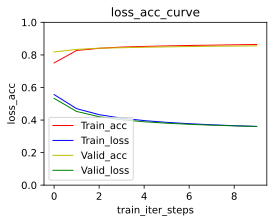

In [14]:
#展示BERT模型训练集和验证集的损失和准确率
train.show_loss_acc_value()

![svg](output_16_0.svg)

In [15]:
#定义BERT模型评估函数
def BERT_Evaluation(model,valid_loader):
    model.eval()
    pred_list = []
    label_list = []
    for idx,(input_ids,attention_mask,token_type_ids,labels) in enumerate(valid_loader):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        pred = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids).argmax(dim=1).cpu().tolist()
        pred_list += pred
        label_list += labels.tolist()
    f1 = f1_score(label_list, pred_list, average='macro')
    Accuracy_score = accuracy_score(label_list, pred_list)
    Recall_score = recall_score(label_list, pred_list,average='macro')
    print(f'Accuracy_score:{Accuracy_score}')
    print(f'Recall_score:{Recall_score}')
    print(f'f1_score:{f1}') 

In [16]:
#BERT模型评估函数对模型进行评价
BERT_Evaluation(model,valid_loader)

Accuracy_score:0.8556385869565217
Recall_score:0.8303337228736352
f1_score:0.8488731598634246


In [17]:
#定义预测网购评论的对象类别函数
def predict_category(model,test_set,test_sents):
    for idx,(input_ids,attention_mask,token_type_ids,labels) in enumerate(test_loader):
        total_num = input_ids.shape[0]
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        pred = model(input_ids=input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids).argmax(dim=1).cpu()
        flag = (pred == labels).tolist()
        true_pred = sum(flag)
        labels =[idx2class[label] for label in labels.tolist()]
        pred = [idx2class[pred] for pred in pred.tolist()]
        flag = ['正确' if f==True else '错误' for f in flag]
    for i in range(len(test_sents)):
        print('Comment:'+str(i+1)+test_sents[i]+' '+'预测类别为:'+pred[i]+' '+'真实类别为:'+labels[i]+' '+'预测'+flag[i])
    acc = round(true_pred/total_num,4)
    print(f'测试数据的准确率为：{acc}')

In [18]:
#调用预测网购评论的对象类别函数对测试数据进行分析
test_sents = df['review'][60000:].values #取出测试集评论
predict_category(model,test_loader,test_sents)

Comment:1真的不敢相信那个酒店就是照片上的 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:2位置离机场不远，但是服务差劲极了，给了钥匙里面 有人，而且不是一次情况，前面入住的已经发生过还是这样，房间设施一般，卫生一般，不会再来 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:3服务不好！态度表面很好，见人就问好，但是目无表情，明显是装出来的。房间的设施太简单。没有家的感觉。 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:4我住的是大床间，房子不算干净，卫生间比较简陋，早餐品种太少，饭店上菜太慢，卫生也是问题，不停有苍蝇转来转去。下次不会再住了。 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:5环境不怎样，住了一天就换了！性价比不高，服务有待改进！ 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:6服务太差，环境污染，态度恶劣，价格较高。 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:7客房硬件过的去，由于我经常出差在外看过的酒店实在不少。不过服务的质量存在很大问题，我在大堂酒吧使用的饮料竟然有脏东西在里面。服务员态度也没太多在意。这点让我不满意，希望酒店方着手提高服务员的素质。 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:8说老实话，我还没有见过这么差的酒店呢！前台服务人员素质极低，还给我信用卡用扔的方式，打电话给前台直接挂我的电话。我不知道是不是价格低一点，就有了别人非住不可的自信。总之，非常差，希望以后取得朋友们注意了。尽量不要选择这个酒店，除了生气，不被尊重，可别指望能够享受到什么服务。 预测类别为:酒店 真实类别为:酒店 预测正确
Comment:9太大的霉味了 难受 预测类别为:衣服 真实类别为:酒店 预测错误
Comment:10入住两个晚上（5/30-6/1日），第一晚上被蚊子咬的无法睡觉，5月31日找前台换房间，既然还告诉我这房间是他们最好的，就是有点蚊子而已；离店时还无法提供发票，说是税务部门还没有批发票给他们（税务部门没批也可以营业吗？）。整体服务实在让人难以接受。 预测类别为:酒店 真实类别为:酒店 预测正确
测试数据的准确率为：0.9
